# Modified TPC-H Q1 Microbenchmark
This file is adapted to use numpy only without Spark.

```sql
select
  sum(l_quantity) as sum_qty,
  sum(l_extendedprice) as sum_base_price,
  sum(l_extendedprice * (1 - l_discount)) as sum_disc_price,
  sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge,
  avg(l_quantity) as avg_qty,
  avg(l_extendedprice) as avg_price,
  avg(l_discount) as avg_disc,
  count(*) as count_order
from
  lineitem
where
  l_shipdate <= '1998-09-02'
  and l_returnflag = 'A'
  and l_linestatus = 'F'
```

In [1]:
EXPERIMENT = 'pac-q1-svd'
OUTPUT_DIR = f'./outputs/{EXPERIMENT}'
GENERATE = True
USE_EVEN_NUMBER_OF_INPUT_ROWS = False
SEED_RANDOM_NUMBER_GENERATOR = True

SAMPLING_METHOD = 'poisson' # 'poisson' or 'half'

if GENERATE:
    print("GENERATE = True, so we will generate new samples.")
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)


GENERATE = True, so we will generate new samples.


### Running PAC

In [9]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
if SEED_RANDOM_NUMBER_GENERATOR:
    np.random.seed(0)

import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from numpy.random import laplace
from functools import reduce
import operator
from IPython.display import display, HTML
from datetime import date
from scipy import special

In [3]:
### Mayuri's conversion functions between DP epsilon and PAC MI using posterior advantage for equivalence
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

def dp_epsilon_to_posterior_success(epsilon):
    return 1 - 1./(1+np.exp(epsilon))

def dp_ps_to_epsilon(ps):
    return np.log(ps / (1-ps))

# example usage:
# dp_ps_to_epsilon(calc_posterior(1/256.))

In [4]:
### Data Setup
#por_df = pq.read_table(f"./data/student_performance/student-por.parquet").to_pandas()
lineitem_df = pd.read_parquet('data/tpch/lineitem.parquet')

lineitem_df.shape

(600572, 16)

In [5]:
type(lineitem_df['l_linestatus'][0])

str

In [6]:
def runquery(lineitem_df: DataFrame) -> int:
    # 1. Filter lineitem rows where commit date is before receipt date.
    lineitem_filtered = lineitem_df[
        (lineitem_df['l_shipdate'] <= date(1998, 9, 2)) &
        (lineitem_df['l_returnflag'] == 'A') &
        (lineitem_df['l_linestatus'] == 'F')
    ]
    print(lineitem_filtered.shape)

    # 2. Pre-compute
    discounted_price = lineitem_filtered['l_extendedprice'] * (1 - lineitem_filtered['l_discount'])
    charged_price = discounted_price * (1 + lineitem_filtered['l_tax'])

    # 3. Get aggregations
    aggregated_result = [
        float(lineitem_filtered['l_quantity'].sum()),       # sum_qty
        float(lineitem_filtered['l_extendedprice'].sum()),  # sum_base_price
        float(discounted_price.sum()),                      # sum_disc_price
        float(charged_price.sum()),                         # sum_charge
        float(lineitem_filtered['l_quantity'].mean()),      # avg_qty
        float(lineitem_filtered['l_extendedprice'].mean()), # avg_price
        float(lineitem_filtered['l_discount'].mean()),      # avg_disc
        float(len(lineitem_filtered))                       # count_order (faster than .count())
    ]

    # print(aggregated_result)

    return aggregated_result
runquery(lineitem_df)

(147790, 16)


[3774200.0,
 5320753880.69,
 5054096266.6828,
 5256751331.449234,
 25.537587116854997,
 36002.12382901414,
 0.05014459706340077,
 147790.0]

In [7]:
### Query Setup
SAMPLES = 8192
assert SAMPLES % 2 == 0, "We need an even number of samples for paired sampling."
number_of_pairs = SAMPLES // 2

OUTPUT_COLS = ['sum_qty', 'sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order']

true_result = np.array(runquery(lineitem_df)) # Save the true result of the query for later
#true_result = np.divide(true_result, 2) # manually correct count = count * 2

number_of_contributing_rows = 147790  # hardcode number of eligible rows

def poisson_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select a subset of indices, where each index is selected with probability 0.5.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    mask = np.random.random_sample(len(df)) < 0.5  # Generates a bitmask of length df.shape[0] where each bit is 1 with probability 0.5
    selected = df[mask]
    not_selected = df[~mask]
    return selected, not_selected

def half_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select half of the row indices from the dataframe at random.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    indices = np.random.choice(df.index, size=(df.shape[0] // 2), replace=False)
    not_indices = list(set(df.index) - set(indices))
    selected: DataFrame = df.loc[indices]
    not_selected: DataFrame = df.loc[not_indices]
    return (selected, not_selected)

def sample_using_chosen_method(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    if SAMPLING_METHOD == 'poisson':
        return poisson_paired_sample(df)
    elif SAMPLING_METHOD == 'half':
        return half_paired_sample(df)

def generate_samples(laplace_lambda: float = 1.0, alpha: int = 10) -> List[np.ndarray]:
    # Apply thresholding: if there are less than alpha samples
    # (with some Laplacian noise), then we don't subsample and return None.
    laplace_noise: float = np.random.laplace(scale=laplace_lambda)

    if number_of_contributing_rows + laplace_noise < alpha:  # if we don't get enough results from the query
        print("There are not enough rows contributing to the result for PAC to be meaningful.")
        return []
    
    number_of_pairs = SAMPLES // 2
    out_np: List[np.ndarray] = []
    for i in range(number_of_pairs):
        print(f'iteration : {i}')
        for temp_df in sample_using_chosen_method(lineitem_df.reset_index(drop=True)):  # reset index to sequential
            out = runquery(temp_df)
            # double the sums and counts, avg stays the same
            out[0] *= 2
            out[1] *= 2
            out[2] *= 2
            out[3] *= 2
            out[7] *= 2
            # for a 2d array, flatten it
            out_np.append(np.array(out))
    # Debug: SVD new (not needed I think??)
    # out_np = reduce(operator.iconcat, out_np, [])

    return out_np

(147790, 16)


In [11]:
### Compute PAC Noise
def get_pac_noise_scale(out_np_raw: List[np.ndarray],
                           max_mi: float = 1./4, use_svd: bool = False) -> np.ndarray:
    if out_np_raw is None or len(out_np_raw) == 0:
        raise ValueError("Input list out_np cannot be empty.")
    out_np = out_np_raw.copy()
    # print(out_np)
    dimensions: int = len(out_np[0])
    print(f'The dimensions are - {dimensions}')

    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays
    print(out_np_2darr)
    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, len(out_np))  # shape (dimensions, samples)
    print(f"est_y.shape: {est_y.shape}")
    print(f"est_y: {est_y}")

    # Debug: SVD new
    if use_svd:
        cov = np.cov(est_y)
        fin_var, u = np.linalg.eig(cov)
    else:
        u = None

    variance = np.array([fin_var[1]])
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(variance))
    pac_var: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(variance)

    # get the scale in each basis direction
    fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)
    print(f"fin_var: {fin_var}")
    # fin_var: np.ndarray = np.array([float(x) for x in fin_var], dtype=np.float64)
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))
    print(f"sqrt_total_var: {sqrt_total_var}")

    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # scale of the PAC noise
    print(f"For mi={max_mi}, we should add noise from a normal distribution with scale...")
    print(f"\t{1./(2*max_mi)} * {sqrt_total_var} * {np.sqrt(fin_var)} = {pac_noise}")
    print(f"pac_noise: {pac_noise}")
    return pac_noise

def do_pac_and_release(out_np: List[np.ndarray],
                       max_mi: float = 1./4,
                       scale: np.ndarray = None,
                       chosen_index: int = None) -> np.ndarray:
    
    if scale is not None:
        pac_noise: np.ndarray = scale
    else:
        pac_noise = get_pac_noise_scale(out_np, max_mi)

    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)
    # Add noise element-wise to the outputs
    if chosen_index is None:  # allow for overriding the chosen index to specify which sample to use for the release
        chosen_index = np.random.choice(range(SAMPLES))
    pac_release = out_np[chosen_index] + pac_noises_to_add
    
    return pac_release

In [19]:
# TODO: remove this once the samples are generated correctly
num_sublists = SAMPLES 
sublist_length = len(out_np) // num_sublists  

# Reshape using numpy
original_out_np = np.array(out_np).reshape(num_sublists, sublist_length).tolist()

len(original_out_np)

original_out_np[0]

out_np = original_out_np


To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [25]:
MI_OPTIONS = [0.001248318631131131, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]
EXPERIMENTS = 1000

if GENERATE:
    # df = pd.DataFrame([], columns=['mi', 'count', 'sum', 'mean', 'var'])
    # experiment_results = []
    # saved_steps = []

    # out_np = generate_samples() # generate samples (results of running the query)
    # print(f"Generate samples... {len(out_np)} samples generated.")

    # print(out_np[0])

    for mi in MI_OPTIONS:
        print("Getting PAC Noise...")
        pac_noise = get_pac_noise_scale(out_np, mi, use_svd=True) # estimate the stability of the query
        print(f"mi={mi}, scale={pac_noise}")
        
        for e in range(EXPERIMENTS):
            # Debug: This is total variance I think??
            # pac_noise *= 2
            # pac_noise = pac_noise**(0.5)
            # pac_noise /= 2
            # pac_noise = [special.erf(x) for x in pac_noise]
    
            # for each PAC release at this MI, we will choose a sample from the pre-generated out_np list and add noise to it
            steps = {
                "mi": mi,
                "scale": pac_noise,
            }

            # choose our sample
            chosen_index = np.random.choice(range(SAMPLES))
            chosen_sample = out_np[chosen_index].copy()
            steps["chosen_sample"] = chosen_sample
            
            # add noise to it
            # chosen_noise will also be an array
            
            chosen_noise = np.random.normal(loc=0, scale=np.sqrt(pac_noise))
            steps["chosen_noise"] = chosen_noise
            
            print(f'Chosen Sample {chosen_sample}')
            # chosen_sample = np.array([float(x) for x in chosen_sample], dtype=np.float64)
            release = chosen_sample + chosen_noise # do_pac_and_release(out_np, mi, scale, chosen_index)

            #print(f"sample(#{chosen_index}):{chosen_sample} + noise:{chosen_noise} = {release}")
            steps["release"] = release
            #release[0] *= 2   # manually correct count = count * 2

            # manually add sum as count * mean
            #noisy_output = [noisy_output[0], noisy_output[0] * noisy_output[1], noisy_output[1]]
            #chosen_sample = [chosen_sample[0], chosen_sample[0] * chosen_sample[1], chosen_sample[1]]
            experiment_results.append([mi, *release])
            saved_steps.append(steps)
    
    df = pd.DataFrame(experiment_results, columns=['mi', *OUTPUT_COLS])
    
    # Save the new data to outputs/...
    df.to_parquet(f'{OUTPUT_DIR}/pac_results.parquet')
    with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
        pickle.dump(experiment_results, f)
    with open(f'{OUTPUT_DIR}/saved_steps.pkl', 'wb') as f:
        pickle.dump(saved_steps, f)
else:
    df = pq.read_table(f"{OUTPUT_DIR}/pac_results.parquet").to_pandas()

    with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'rb') as f:
        experiment_results = pickle.load(f)
    with open(f'{OUTPUT_DIR}/saved_steps.pkl', 'rb') as f:
        saved_steps = pickle.load(f)

# df.head()

Getting PAC Noise...
The dimensions are - 8
[array([[3.76986800e+06, 5.31825915e+09, 5.05263840e+09, 5.25522537e+09,
        2.55813202e+01, 3.60882902e+04, 5.00074643e-02, 1.47368000e+05]]), array([[3.77853200e+06, 5.32324861e+09, 5.05555414e+09, 5.25827729e+09,
        2.54941030e+01, 3.59164482e+04, 5.02809489e-02, 1.48212000e+05]]), array([[3.77564200e+06, 5.32335525e+09, 5.05692265e+09, 5.25916564e+09,
        2.55739928e+01, 3.60572980e+04, 5.00857514e-02, 1.47636000e+05]]), array([[3.77275800e+06, 5.31815252e+09, 5.05126989e+09, 5.25433702e+09,
        2.55012572e+01, 3.59470645e+04, 5.02033202e-02, 1.47944000e+05]]), array([[3.77377600e+06, 5.31962160e+09, 5.05351049e+09, 5.25651699e+09,
        2.55475101e+01, 3.60124943e+04, 5.01150857e-02, 1.47716000e+05]]), array([[3.77462400e+06, 5.32188616e+09, 5.05468205e+09, 5.25698568e+09,
        2.55276741e+01, 3.59917638e+04, 5.01740789e-02, 1.47864000e+05]]), array([[3.77953400e+06, 5.32392994e+09, 5.05618576e+09, 5.25921345e+09,
 

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'float'

In [13]:
saved_steps_df_temp = pd.DataFrame(saved_steps)
saved_steps_df_temp.head()

mi                                              scale  \
0  0.001248  [227245569704930.03, 3.2939518077816416e+17, 3...   
1  0.001248  [227245569704930.03, 3.2939518077816416e+17, 3...   
2  0.001248  [227245569704930.03, 3.2939518077816416e+17, 3...   
3  0.001248  [227245569704930.03, 3.2939518077816416e+17, 3...   
4  0.001248  [227245569704930.03, 3.2939518077816416e+17, 3...   

                                       chosen_sample  \
0  [3754110.0, 5295394259.2, 5029937349.553, 5231...   
1  [3777718.0, 5324997798.6, 5058298368.5832, 526...   
2  [3766494.0, 5309078181.4, 5044272905.5464, 524...   
3  [3767388.0, 5306107615.68, 5039002027.2056, 52...   
4  [3787130.0, 5341541610.52, 5073338598.7894, 52...   

                                        chosen_noise  \
0  [-1286390.418446158, -237803289.78646737, -780...   
1  [-4742703.3846065495, 338739091.6697759, -1933...   
2  [-2172067.4591480438, -60012370.677399695, 620...   
3  [2155775.697452062, -751522665.0613272, 156780...   
4  [9499816.270443637, 270903247.8842127, 2230825...   

                                             release  
0  [2467719.581553842, 5057590969.413532, 4249033...  
1  [-964985.3846065495, 5663736890.269776, 486494...  
2  [1594426.5408519562, 5249065810.7226, 56652481...  
3  [5923163.697452062, 4554584950.618673, 5195782...  
4  [13286946.270443637, 5612444858.404213, 529642...

In [14]:
### Reconstruct Saved Steps
# Get list of keys from the first dict, excluding 'mi' since it's not a list
steps = [k for k in saved_steps[0].keys() if k not in ('mi')] # pull keys from saved_steps[0]

saved_steps_df_temp = pd.DataFrame(saved_steps)

# Create expanded columns using comprehension
expanded = {
    'mi': saved_steps_df_temp['mi'],
    **{f'{step}_{col}': saved_steps_df_temp[step].str[i] 
        for step in steps
        for i, col in enumerate(OUTPUT_COLS)}
}

# Create MultiIndex DataFrame using OUTPUT_COLS
saved_steps_df = pd.DataFrame(expanded)
saved_steps_df.columns = pd.MultiIndex.from_tuples([('mi',''), *[  # multiindex so that we can do things like saved_steps_df['release'][<aggregation>]
    (step, col) for step in steps for col in OUTPUT_COLS
]], names=["step", "query"])
saved_steps_df.head()

step         mi         scale                                              \
query                 sum_qty sum_base_price sum_disc_price    sum_charge   
0      0.001248  2.272456e+14   3.293952e+17   3.131058e+17  3.258321e+17   
1      0.001248  2.272456e+14   3.293952e+17   3.131058e+17  3.258321e+17   
2      0.001248  2.272456e+14   3.293952e+17   3.131058e+17  3.258321e+17   
3      0.001248  2.272456e+14   3.293952e+17   3.131058e+17  3.258321e+17   
4      0.001248  2.272456e+14   3.293952e+17   3.131058e+17  3.258321e+17   

step                                                          chosen_sample  \
query       avg_qty     avg_price      avg_disc   count_order       sum_qty   
0      7.442367e+08  1.145584e+12  1.621763e+06  7.787051e+12     3754110.0   
1      7.442367e+08  1.145584e+12  1.621763e+06  7.787051e+12     3777718.0   
2      7.442367e+08  1.145584e+12  1.621763e+06  7.787051e+12     3766494.0   
3      7.442367e+08  1.145584e+12  1.621763e+06  7.787051e+12     3767388.0   
4      7.442367e+08  1.145584e+12  1.621763e+06  7.787051e+12     3787130.0   

step   ... chosen_noise                     release                 \
query  ...     avg_disc   count_order       sum_qty sum_base_price   
0      ...   474.396466  6.998456e+05  2.467720e+06   5.057591e+09   
1      ... -2796.328972 -7.537713e+05 -9.649854e+05   5.663737e+09   
2      ... -1545.666331  3.127316e+06  1.594427e+06   5.249066e+09   
3      ...  -287.036566  7.987525e+05  5.923164e+06   4.554585e+09   
4      ...   622.855034  5.212110e+06  1.328695e+07   5.612445e+09   

step                                                                         \
query sum_disc_price    sum_charge       avg_qty     avg_price     avg_disc   
0       4.249034e+09  4.614427e+09  20766.575311 -4.304908e+05   474.446607   
1       4.864946e+09  6.032766e+09   1503.909600 -6.795073e+05 -2796.278867   
2       5.665248e+09  5.572871e+09  11461.478242  6.924098e+05 -1545.616309   
3       5.195782e+09  4.973658e+09 -29137.755849  1.792792e+06  -286.986346   
4       5.296421e+09  5.324594e+09  40983.654863 -8.391079e+05   622.905198   

step                 
query   count_order  
0      8.472516e+05  
1     -6.057053e+05  
2      3.274772e+06  
3      9.465245e+05  
4      5.359966e+06  

[5 rows x 33 columns]

In [15]:
saved_steps_df.groupby('mi').mean()

/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_75159/2569112584.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  saved_steps_df.groupby('mi').mean()


step              scale                                              \
query           sum_qty sum_base_price sum_disc_price    sum_charge   
mi                                                                    
0.001248   2.272456e+14   3.293952e+17   3.131058e+17  3.258321e+17   
0.015625   1.815519e+13   2.631617e+16   2.501477e+16  2.603150e+16   
0.031250   9.077596e+12   1.315808e+16   1.250739e+16  1.301575e+16   
0.062500   4.538798e+12   6.579042e+15   6.253693e+15  6.507876e+15   
0.250000   1.134700e+12   1.644761e+15   1.563423e+15  1.626969e+15   
1.000000   2.836749e+11   4.111901e+14   3.908558e+14  4.067422e+14   
2.000000   1.418374e+11   2.055951e+14   1.954279e+14  2.033711e+14   
4.000000   7.091872e+10   1.027975e+14   9.771396e+13  1.016856e+14   
16.000000  1.772968e+10   2.569938e+13   2.442849e+13  2.542139e+13   

step                                                               \
query           avg_qty     avg_price      avg_disc   count_order   
mi                                                                  
0.001248   7.442367e+08  1.145584e+12  1.621763e+06  7.787051e+12   
0.015625   5.945885e+07  9.152344e+10  1.295665e+05  6.221261e+11   
0.031250   2.972943e+07  4.576172e+10  6.478326e+04  3.110631e+11   
0.062500   1.486471e+07  2.288086e+10  3.239163e+04  1.555315e+11   
0.250000   3.716178e+06  5.720215e+09  8.097907e+03  3.888288e+10   
1.000000   9.290446e+05  1.430054e+09  2.024477e+03  9.720721e+09   
2.000000   4.645223e+05  7.150269e+08  1.012238e+03  4.860361e+09   
4.000000   2.322611e+05  3.575135e+08  5.061192e+02  2.430180e+09   
16.000000  5.806529e+04  8.937836e+07  1.265298e+02  6.075451e+08   

step      chosen_sample                 ... chosen_noise                 \
query           sum_qty sum_base_price  ...     avg_disc    count_order   
mi                                      ...                               
0.001248    3773991.716   5.320358e+09  ...   -11.503186  116052.766618   
0.015625    3773950.112   5.320303e+09  ...    32.755107  -23336.354805   
0.031250    3774197.670   5.320858e+09  ...    -9.062205   -4185.033767   
0.062500    3774228.142   5.320790e+09  ...     3.884286    7196.675682   
0.250000    3774882.636   5.321698e+09  ...    -3.050651    5127.182090   
1.000000    3773398.448   5.319489e+09  ...    -0.331424    1414.333050   
2.000000    3774066.810   5.320867e+09  ...    -0.758369   -1062.973120   
4.000000    3773946.172   5.320305e+09  ...     1.219836     -14.483615   
16.000000   3774109.228   5.320542e+09  ...    -0.174003   -1034.753192   

step            release                                              \
query           sum_qty sum_base_price sum_disc_price    sum_charge   
mi                                                                    
0.001248   3.981612e+06   5.278430e+09   5.061387e+09  5.249399e+09   
0.015625   3.844465e+06   5.320078e+09   5.061179e+09  5.256113e+09   
0.031250   3.546047e+06   5.324768e+09   5.048034e+09  5.261396e+09   
0.062500   3.792876e+06   5.323004e+09   5.054280e+09  5.256317e+09   
0.250000   3.773919e+06   5.320007e+09   5.053433e+09  5.256704e+09   
1.000000   3.768952e+06   5.320099e+09   5.053741e+09  5.256132e+09   
2.000000   3.762193e+06   5.320661e+09   5.054136e+09  5.257376e+09   
4.000000   3.780052e+06   5.320879e+09   5.053568e+09  5.256487e+09   
16.000000  3.777558e+06   5.320386e+09   5.053957e+09  5.256602e+09   

step                                                           
query         avg_qty     avg_price   avg_disc    count_order  
mi                                                             
0.001248   -62.549530  -2240.245543 -11.453044  263840.906618  
0.015625    50.572286  43347.126015  32.805252  124454.671195  
0.031250  -312.777591  33028.754222  -9.012063  143602.936233  
0.062500     5.401782  35648.814845   3.934433  154993.673682  
0.250000   -69.528522  34506.277718  -3.000503  152932.792090  
1.000000     7.766948  35520.159551  -0.281284  1491

<Axes: >

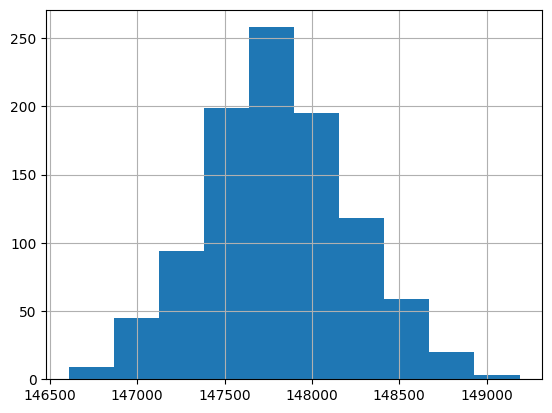

In [16]:
saved_steps_df[saved_steps_df['mi'] == 1/4]['chosen_sample']['count_order'].hist()

In [17]:
if ('mean' in OUTPUT_COLS):
    print("Mean of chosen_sample['mean'] for mi = 1/32")
    saved_steps_df[saved_steps_df['mi'] == 1/32]['chosen_sample']['mean'].hist()

In [18]:
if ('mean' in OUTPUT_COLS):
    print("Mean of release['mean'] for mi = 1/32")
    saved_steps_df[saved_steps_df['mi'] == 1/32]['release']['mean'].hist()

In [19]:
### DEBUG: Save the variables from computing the PAC noises for later reverse engineering
#if GENERATE:
#    saved_pac_variables_df = pd.DataFrame(saved_pac_variables, columns=['mi', 'out_np_0', 'fin_var', 'sqrt_total_var', 'pac_noise', 'pac_noises_to_add', 'pac_release'])
#    saved_pac_variables_df.to_parquet(f'{OUTPUT_DIR}/saved_pac_variables.parquet')
#else:
#    saved_pac_variables_df = pq.read_table(f"{OUTPUT_DIR}/saved_pac_variables.parquet").to_pandas()
#saved_pac_variables_df.head()

### Computing PAC Errors

In [20]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

In [21]:
#OUTPUT_COLS = OUTPUT_COLS
ERROR_COLS = [*[f'absolute error {i}' for i in OUTPUT_COLS], *[f'relative error {i}' for i in OUTPUT_COLS]]

In [22]:
print(true_result)

[3.77420000e+06 5.32075388e+09 5.05409627e+09 5.25675133e+09
 2.55375871e+01 3.60021238e+04 5.01445971e-02 1.47790000e+05]


In [23]:
true_result = np.array(runquery(lineitem_df))

(147790, 16)


In [24]:
# compute errors for PAC (or import from saved file)
if GENERATE:
    errors_list = []
    for i, row in df.iterrows():
        print(row)
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    pac_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    pac_errors_df.to_parquet(f"{OUTPUT_DIR}/pac_errors.parquet")  # overwrite saved
else:
    pac_errors_df = pq.read_table(f"{OUTPUT_DIR}/pac_errors.parquet").to_pandas()
pac_errors_df

mi                1.248319e-03
sum_qty           2.467720e+06
sum_base_price    5.057591e+09
sum_disc_price    4.249034e+09
sum_charge        4.614427e+09
avg_qty           2.076658e+04
avg_price        -4.304908e+05
avg_disc          4.744466e+02
count_order       8.472516e+05
Name: 0, dtype: float64
mi                1.248319e-03
sum_qty          -9.649854e+05
sum_base_price    5.663737e+09
sum_disc_price    4.864946e+09
sum_charge        6.032766e+09
avg_qty           1.503910e+03
avg_price        -6.795073e+05
avg_disc         -2.796279e+03
count_order      -6.057053e+05
Name: 1, dtype: float64
mi                1.248319e-03
sum_qty           1.594427e+06
sum_base_price    5.249066e+09
sum_disc_price    5.665248e+09
sum_charge        5.572871e+09
avg_qty           1.146148e+04
avg_price         6.924098e+05
avg_disc         -1.545616e+03
count_order       3.274772e+06
Name: 2, dtype: float64
mi                1.248319e-03
sum_qty           5.923164e+06
sum_base_price    4.554585e+0

mi  absolute error sum_qty  absolute error sum_base_price  \
0      0.001248            1.306480e+06                   2.631629e+08   
1      0.001248            4.739185e+06                   3.429830e+08   
2      0.001248            2.179773e+06                   7.168807e+07   
3      0.001248            2.148964e+06                   7.661689e+08   
4      0.001248            9.512746e+06                   2.916910e+08   
...         ...                     ...                            ...   
8995  16.000000            2.714007e+05                   1.055463e+07   
8996  16.000000            8.653517e+04                   2.657687e+05   
8997  16.000000            2.883919e+04                   1.305433e+07   
8998  16.000000            1.338102e+05                   2.932178e+06   
8999  16.000000            4.408609e+04                   9.112234e+06   

      absolute error sum_disc_price  absolute error sum_charge  \
0                      8.050623e+08               6.423243e+08   
1                      1.891504e+08               7.760151e+08   
2                      6.111519e+08               3.161200e+08   
3                      1.416861e+08               2.830934e+08   
4                      2.423249e+08               6.784254e+07   
...                             ...                        ...   
8995                   5.116841e+06               7.181395e+06   
8996                   3.629153e+06               7.606329e+06   
8997                   1.496141e+07               1.541867e+07   
8998                   9.549034e+05               2.044778e+06   
8999                   4.577159e+06               1.179470e+07   

      absolute error avg_qty  absolute error avg_price  \
0               20741.037724              4.664929e+05   
1                1478.372013              7.155094e+05   
2               11435.940655              6.564076e+05   
3               29163.293436              1.756789e+06   
4               40958.117276              8.751100e+05   
...                      ...                       ...   
8995              105.736307              1.301886e+04   
8996               54.623209              1.460250e+04   
8997              413.321844              4.976978e+03   
8998               26.255938              1.502037e+04   
8999              163.760909              6.046292e+03   

      absolute error avg_disc  absolute error count_order  \
0                  474.396462                6.994616e+05   
1                 2796.329011                7.534953e+05   
2                 1545.666454                3.126982e+06   
3                  287.036490                7.987345e+05   
4                  622.855053                5.212176e+06   
...                       ...                         ...   
8995                 3.597788                7.766831e+03   
8996                 2.383121                2.419069e+04   
8997                 3.092949                1.225768e+04   
8998                19.478468                3.276664e+04   
8999                24.760980                6.703347e+02   

      relative error sum_qty  relative error sum_base_price  \
0                  34.616089                       4.945970   
1                 125.567945                       6.446136   
2                  57.754583                       1.347329   
3                  56.938257                      14.399631   
4                 252.046693                       5.482136   
...                      ...                            ...   
8995                7.190946                       0.198367   
8996                2.292808                       0.004995   
8997                0.764114                       0.245347   
8998                3.545391                       0.055108   
8999                1.168091                       0.171258   

      relative error sum_disc_price  relative error sum_charge  \
0                         15.928908                  12.219035   
1           

In [25]:
# if GENERATE:
#     mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
#     std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
#     mean_df, std_df

#     # save mean_df, std_df to parquet
#     mean_df.to_parquet('{OUTPUT_DIR}/pac-mean_df_student-por.parquet')
#     std_df.to_parquet('{OUTPUT_DIR}/pac-std_df_student-por.parquet')

### Computing DP Errors

### Analysis of PAC vs DP
- import the DP data
- create a dataframe (`all_df`) containing the query outputs
    - in this df, each output is the {mean, variance} aggregation over the 500 experiments, grouped by the type of privacy mechanism used (pac or dp) and privacy factor (mi or epsilon)
- create a dataframe in the same pattern containing the computed error for each privitized output

In [26]:
%%script echo skipping# Import Chais saved data from running PipelineDP and use it to compare.
dp_results_df = pq.read_table(f"{OUTPUT_DIR}/dp-q4/dp_results.parquet").to_pandas()

# compute sum from count and mean
dp_results_df['sum'] = dp_results_df['count'] * dp_results_df['mean']
dp_results_df = dp_results_df[['mi', 'count', 'sum', 'mean']]

# filter to just MI_OPTIONS
dp_results_df = dp_results_df[dp_results_df['mi'].isin(MI_OPTIONS)]

dp_results_df

skipping# Import Chais saved data from running PipelineDP and use it to compare.


In [27]:
%%script echo skipping# compute errors for DP (or import from saved file)
GENERATE_DP = True
if GENERATE_DP:
    errors_list = []
    for i, row in dp_results_df.iterrows():
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    dp_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    dp_errors_df.to_parquet(f"{OUTPUT_DIR}/dp-q4/dp_errors.parquet")  # overwrite saved
else:
    dp_errors_df = pq.read_table(f"{OUTPUT_DIR}/dp-q4/dp_errors.parquet").to_pandas()
dp_errors_df

skipping# compute errors for DP (or import from saved file)


In [28]:
### Make one merged DF to compare results
all_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_results_df.assign(type='dp').rename(columns={'eps': 'factor'}), # switch from eps to mi for indexing DP results
    #dp_results_df.assign(type='dp').rename(columns={'mi': 'factor'}), # comment out DP results until we have some
    df.assign(type='pac').rename(columns={'mi': 'factor'})
])
all_df = all_df.groupby(['type', 'factor']).agg(['mean', 'var'])
all_df.columns = [' '.join(col).strip() for col in all_df.columns.values]  # Flatten the columns
#all_df.to_parquet(f"{OUTPUT_DIR}/all_results.parquet")  # Save the merged results
all_df

Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/unix_events.py", line 665, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe


sum_qty mean   sum_qty var  sum_base_price mean  \
type factor                                                       
pac  0.001248   3.981612e+06  2.211728e+14         5.278430e+09   
     0.015625   3.844465e+06  1.935557e+13         5.320078e+09   
     0.031250   3.546047e+06  8.331453e+12         5.324768e+09   
     0.062500   3.792876e+06  4.159164e+12         5.323004e+09   
     0.250000   3.773919e+06  1.154417e+12         5.320007e+09   
     1.000000   3.768952e+06  2.649021e+11         5.320099e+09   
     2.000000   3.762193e+06  1.432718e+11         5.320661e+09   
     4.000000   3.780052e+06  7.514733e+10         5.320879e+09   
     16.000000  3.777558e+06  1.669170e+10         5.320386e+09   

                sum_base_price var  sum_disc_price mean  sum_disc_price var  \
type factor                                                                   
pac  0.001248         3.068890e+17         5.061387e+09        3.061600e+17   
     0.015625         2.478057e+16         5.061179e+09        2.470312e+16   
     0.031250         1.364628e+16         5.048034e+09        1.292116e+16   
     0.062500         6.722923e+15         5.054280e+09        6.386451e+15   
     0.250000         2.002275e+15         5.053433e+09        1.855261e+15   
     1.000000         6.975022e+14         5.053741e+09        6.471186e+14   
     2.000000         4.898434e+14         5.054136e+09        4.241654e+14   
     4.000000         3.720411e+14         5.053568e+09        3.307434e+14   
     16.000000        3.238965e+14         5.053957e+09        2.852542e+14   

                sum_charge mean  sum_charge var  avg_qty mean   avg_qty var  \
type factor                                                                   
pac  0.001248      5.249399e+09    3.386481e+17    -62.549530  7.501093e+08   
     0.015625      5.256113e+09    2.505108e+16     50.572286  6.108305e+07   
     0.031250      5.261396e+09    1.325643e+16   -312.777591  3.025636e+07   
     0.062500      5.256317e+09    7.018829e+15      5.401782  1.607360e+07   
     0.250000      5.256704e+09    1.850719e+15    -69.528522  3.840193e+06   
     1.000000      5.256132e+09    6.977009e+14      7.766948  9.290579e+05   
     2.000000      5.257376e+09    4.903266e+14    -33.578219  4.654319e+05   
     4.000000      5.256487e+09    3.715053e+14     33.551420  2.275038e+05   
     16.000000     5.256602e+09    3.075554e+14     16.998790  5.697097e+04   

                avg_price mean  avg_price var  avg_disc mean  avg_disc var  \
type factor                                                                  
pac  0.001248     -2240.245543   1.191310e+12     -11.453044  1.745570e+06   
     0.015625     43347.126015   9.062548e+10      32.805252  1.294640e+05   
     0.031250     33028.754222   4.674424e+10      -9.012063  6.549533e+04   
     0.062500     35648.814845   2.195229e+10       3.934433  3.154862e+04   
     0.250000     34506.277718   5.448190e+09      -3.000503  8.177402e+03   
     1.000000     35520.159551   1.427865e+09      -0.281284  1.867534e+03   
     2.000000     35761.739866   7.007848e+08      -0.708226  9.940428e+02   
     4.000000     35867.207300   3.749483e+08       1.269982  5.146644e+02   
     16.000000    35934.256895   8.646451e+07      -0.123856  1.289350e+02   

                count_order mean  count_order var  
type factor                                        
pac  0.001248      263840.906618     7.538851e+12  
     0.015625      124454.671195     6.285047e+11  
     0.031250      143602.936233     3.182805e+11  
     0.062500      154993.673682     1.632537e+11  
     0.250000      152932.792090     3.531649e+10  
     1.000000      149172.809050     9.746628e+09  
     2.000000      146731.836880     5.062575e+09  
     4.000000      147769.670385     2.343460e+09  
     16.000000     146748.282808     6.150428e+08

In [29]:
### Make another merged df for the errors
errors_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_errors_df.assign(type='dp').rename(columns={'eps': 'factor'}), # switch from eps to mi for indexing DP results
    #dp_errors_df.assign(type='dp').rename(columns={'mi': 'factor'}), # comment out DP results until we have some
    pac_errors_df.assign(type='pac').rename(columns={'mi': 'factor'})
])
errors_df = errors_df.groupby(['type', 'factor']).agg(['mean', 'var'])
# drop absolute * mean and relative * var columns from level 1
#errors_df = errors_df.drop(columns=[('absolute error count', 'mean'), ('absolute error mean', 'mean'), ('relative error count', 'var'), ('relative error mean', 'var')])
errors_df.columns = [' '.join(col).strip() for col in errors_df.columns.values]  # flatten the columns

#errors_df.to_parquet(f"{OUTPUT_DIR}/all_errors.parquet")
errors_df

absolute error sum_qty mean  absolute error sum_qty var  \
type factor                                                               
pac  0.001248                  1.186217e+07                8.036389e+13   
     0.015625                  3.518530e+06                6.968070e+12   
     0.031250                  2.279209e+06                3.183563e+12   
     0.062500                  1.626598e+06                1.511042e+12   
     0.250000                  8.535629e+05                4.251179e+11   
     1.000000                  4.094269e+05                9.713156e+10   
     2.000000                  3.042870e+05                5.073286e+10   
     4.000000                  2.177276e+05                2.772882e+10   
     16.000000                 1.039388e+05                5.888892e+09   

                absolute error sum_base_price mean  \
type factor                                          
pac  0.001248                         4.414299e+08   
     0.015625                         1.272488e+08   
     0.031250                         9.504108e+07   
     0.062500                         6.559697e+07   
     0.250000                         3.590907e+07   
     1.000000                         2.086971e+07   
     2.000000                         1.761452e+07   
     4.000000                         1.548836e+07   
     16.000000                        1.450053e+07   

                absolute error sum_base_price var  \
type factor                                         
pac  0.001248                        1.136266e+17   
     0.015625                        8.572553e+15   
     0.031250                        4.620556e+15   
     0.062500                        2.420721e+15   
     0.250000                        7.120810e+14   
     1.000000                        2.619501e+14   
     2.000000                        1.792704e+14   
     4.000000                        1.319274e+14   
     16.000000                       1.135558e+14   

                absolute error sum_disc_price mean  \
type factor                                          
pac  0.001248                         4.399575e+08   
     0.015625                         1.248333e+08   
     0.031250                         9.224903e+07   
     0.062500                         6.372435e+07   
     0.250000                         3.428346e+07   
     1.000000                         2.001158e+07   
     2.000000                         1.635682e+07   
     4.000000                         1.457712e+07   
     16.000000                        1.360436e+07   

                absolute error sum_disc_price var  \
type factor                                         
pac  0.001248                        1.124569e+17   
     0.015625                        9.154386e+15   
     0.031250                        4.439548e+15   
     0.062500                        2.321627e+15   
     0.250000                        6.791695e+14   
     1.000000                        2.463811e+14   
     2.000000                        1.563536e+14   
     4.000000                        1.183180e+14   
     16.000000                       1.000097e+14   

                absolute error sum_charge mean  absolute error sum_charge var  \
type factor                                                                     
pac  0.001248                     4.628284e+08                   1.242777e+17   
     0.015625                     1.259195e+08                   9.179893e+15   
     0.031250                     9.149441e+07                   4.898422e+15   
     0.062500                     6.659565e+07                   2.579597e+15   
     0.250000                     3.459895e+07                   6.524350e+14   
     1.000000                     2.117854e+07                   2.491059e+14   
     2.000000                     1.789878e+07                   1.700303e+14   
     4.000000                     1.553997e+07                   1.298427e+14   
     16.000000        

In [30]:
#abs_error = errors_df.groupby('mi').mean()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

#std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

# save std_abs_error, sample_mean_rel_error to parquet
# std_abs_error.to_parquet('outputs/pac-std_abs_error_student-por.parquet')
# sample_mean_rel_error.to_parquet('outputs/pac-sample_mean_rel_error_student-por.parquet')

### Plotting Results

We are reproducing Table 14 from this paper: http://arxiv.org/abs/2109.10789

> TABLE 14: Experiments of the queries count, sum, mean, and var on the attribute Absences of the Portuguese education dataset containing 649 individuals (500 experiments per ε).

In [31]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [32]:
import matplotlib.colors as mcolors

PAC_COLOR = 'tab:blue'
DP_COLOR = 'tab:red'

# Function to lighten a color by blending with white
def lighten_color(color, amount=0.3):
    rgba = mcolors.to_rgba(color)
    return tuple(np.clip(np.array(rgba[:3]) + amount, 0, 1)) + (rgba[3],)

# Create lighter colors
PAC_LIGHT = lighten_color(PAC_COLOR, 0.3)
DP_LIGHT = lighten_color(DP_COLOR, 0.3)

# create legend, use color squares
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
pac_dp_legend_handles = [
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP')
]

Reproduction of Table 14 (PAC)

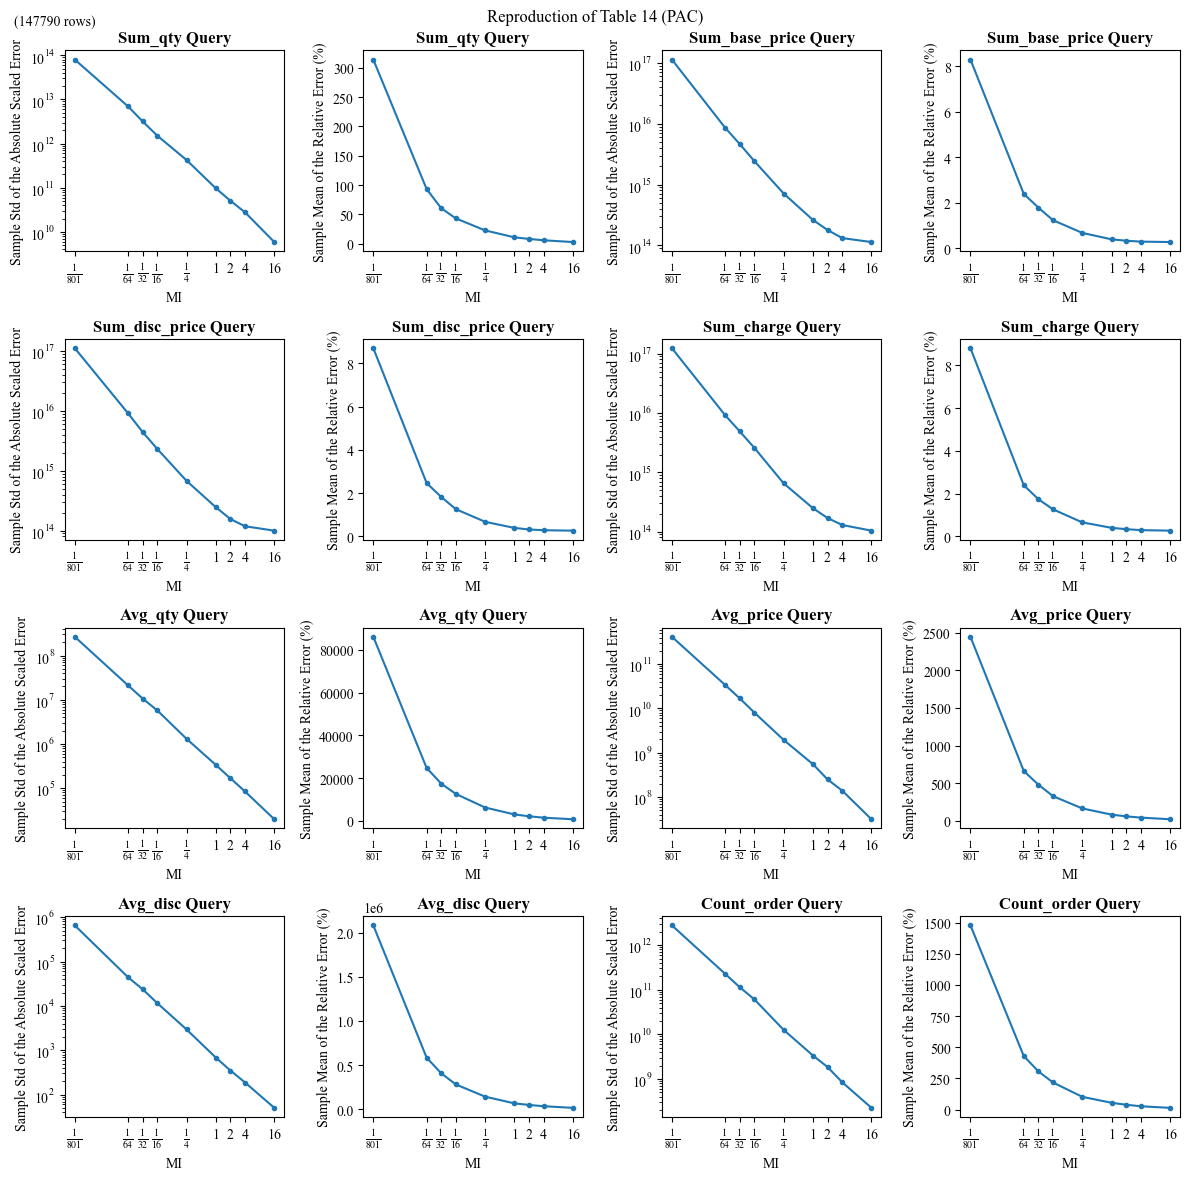

In [33]:
### Reproduction of Table 14 (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
             #label=query, marker='.')

    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.95, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac.jpg", bbox_inches='tight')
plt.show()

Reproduction of Table 14 (DP)

In [34]:
%%script echo skipping### Reproduction of Table 14 (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
             #label=query, marker='.')
    
    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_dp.jpg", bbox_inches='tight')
plt.show()

skipping### Reproduction of Table 14 (DP)


Both on the same axes, aligned

In [35]:
%%script echo skipping
### Both on the same axes, aligned
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    d = errors_df.loc['pac'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'absolute error {query} var']
    #print(d)
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')
    ax1.set_xlabel('MI')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc['pac'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    
    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')
    ax2.set_xlabel('MI')

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False)

fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac_vs_dp.jpg", bbox_inches='tight')
plt.show()

skipping


# Additonal Extra Plotting

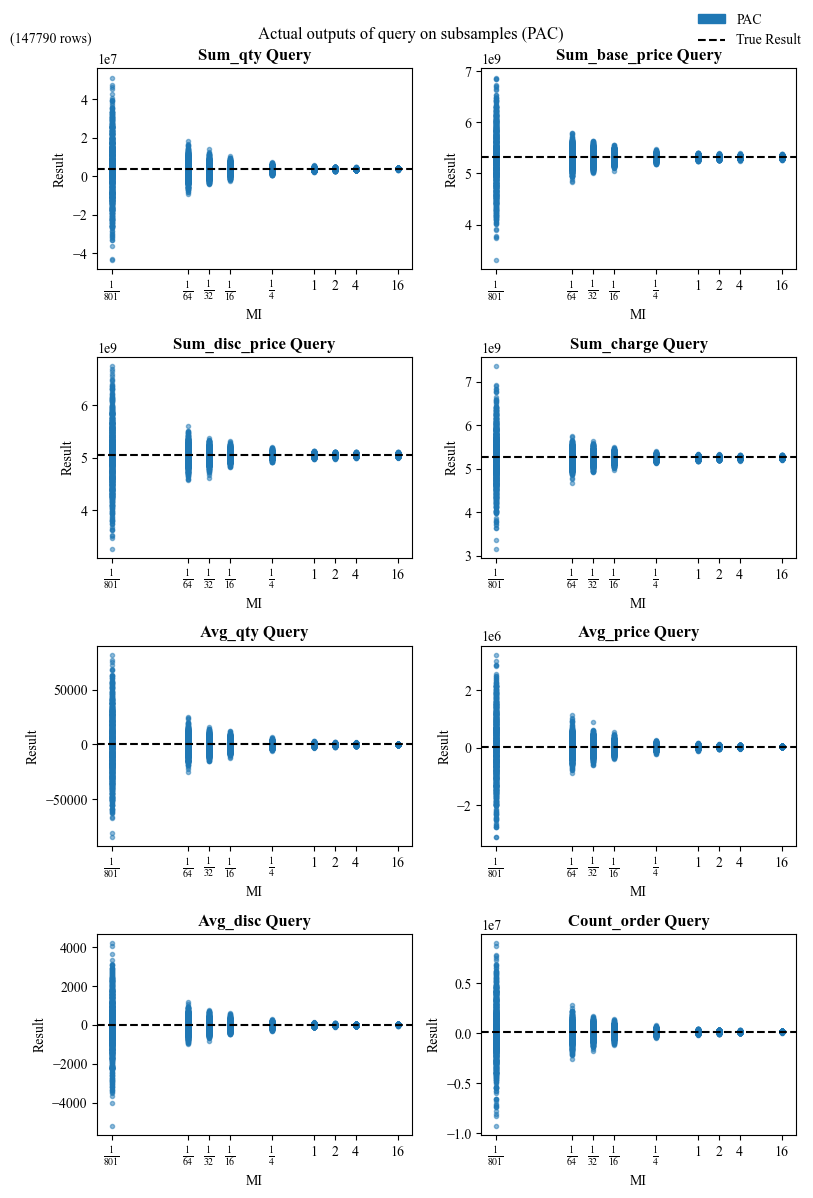

In [36]:
### Plotting the actual experiment outputs used (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(4, 2, figsize=(8,12))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'pac'
    ax.scatter(df['mi'], df[query], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
    
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()

In [37]:
%%script echo skipping### Plotting the actual experiment outputs used (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'dp'

    ax.scatter(dp_results_df['mi'], dp_results_df[query], label=query, marker='.', alpha=0.5, color=DP_COLOR)
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp.jpg", bbox_inches='tight')
plt.show()

skipping### Plotting the actual experiment outputs used (DP)


In [38]:
%%script echo skipping### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.linewidth = 0.25

    # correct answer
    ax.axhline(y=true_result[i], color='gray', linestyle='--', label='True Result')

    for mi in MI_OPTIONS: # categorical variable
        position = MI_OPTIONS.index(mi) * 2

        TYPE = 'pac'

        pac_style = {
            'boxprops': dict(facecolor=PAC_LIGHT),
            'medianprops': dict(color='black')
        }
        
        # mi = mi and query is correct
        d = df[df['mi'] == mi][query].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **pac_style)

        position += 1
        TYPE = 'dp'

        dp_style = {
            'boxprops': dict(facecolor=DP_LIGHT),
            'medianprops': dict(color='black')
        }

        # mi = mi and query is correct
        d = dp_results_df[dp_results_df['mi'] == mi][query].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **dp_style)
    
    
    
    # override xticks, one for each pair of boxplots
    # the x axis is actually artificial here to plot both PAC and DP side by side
    xticks = [0.5+2*i for i in range(len(MI_OPTIONS))]
    ax.set_xticks(xticks)

    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in MI_OPTIONS]
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='gray', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query trials (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp_vs_pac.jpg", bbox_inches='tight')
plt.show()


skipping### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))


In [39]:
df.groupby('mi').var()

sum_qty  sum_base_price  sum_disc_price    sum_charge  \
mi                                                                      
0.001248   2.211728e+14    3.068890e+17    3.061600e+17  3.386481e+17   
0.015625   1.935557e+13    2.478057e+16    2.470312e+16  2.505108e+16   
0.031250   8.331453e+12    1.364628e+16    1.292116e+16  1.325643e+16   
0.062500   4.159164e+12    6.722923e+15    6.386451e+15  7.018829e+15   
0.250000   1.154417e+12    2.002275e+15    1.855261e+15  1.850719e+15   
1.000000   2.649021e+11    6.975022e+14    6.471186e+14  6.977009e+14   
2.000000   1.432718e+11    4.898434e+14    4.241654e+14  4.903266e+14   
4.000000   7.514733e+10    3.720411e+14    3.307434e+14  3.715053e+14   
16.000000  1.669170e+10    3.238965e+14    2.852542e+14  3.075554e+14   

                avg_qty     avg_price      avg_disc   count_order  
mi                                                                 
0.001248   7.501093e+08  1.191310e+12  1.745570e+06  7.538851e+12  
0.015625   6.108305e+07  9.062548e+10  1.294640e+05  6.285047e+11  
0.031250   3.025636e+07  4.674424e+10  6.549533e+04  3.182805e+11  
0.062500   1.607360e+07  2.195229e+10  3.154862e+04  1.632537e+11  
0.250000   3.840193e+06  5.448190e+09  8.177402e+03  3.531649e+10  
1.000000   9.290579e+05  1.427865e+09  1.867534e+03  9.746628e+09  
2.000000   4.654319e+05  7.007848e+08  9.940428e+02  5.062575e+09  
4.000000   2.275038e+05  3.749483e+08  5.146644e+02  2.343460e+09  
16.000000  5.697097e+04  8.646451e+07  1.289350e+02  6.150428e+08

In [40]:
# tables
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap

In [41]:
print("Scale of noise added to [Count, Mean] (scale param passed to Normal noise function)")
saved_steps_df[['mi','scale']].groupby('mi').mean()

Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/unix_events.py", line 665, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe


Scale of noise added to [Count, Mean] (scale param passed to Normal noise function)


step              scale                                              \
query           sum_qty sum_base_price sum_disc_price    sum_charge   
mi                                                                    
0.001248   2.272456e+14   3.293952e+17   3.131058e+17  3.258321e+17   
0.015625   1.815519e+13   2.631617e+16   2.501477e+16  2.603150e+16   
0.031250   9.077596e+12   1.315808e+16   1.250739e+16  1.301575e+16   
0.062500   4.538798e+12   6.579042e+15   6.253693e+15  6.507876e+15   
0.250000   1.134700e+12   1.644761e+15   1.563423e+15  1.626969e+15   
1.000000   2.836749e+11   4.111901e+14   3.908558e+14  4.067422e+14   
2.000000   1.418374e+11   2.055951e+14   1.954279e+14  2.033711e+14   
4.000000   7.091872e+10   1.027975e+14   9.771396e+13  1.016856e+14   
16.000000  1.772968e+10   2.569938e+13   2.442849e+13  2.542139e+13   

step                                                               
query           avg_qty     avg_price      avg_disc   count_order  
mi                                                                 
0.001248   7.442367e+08  1.145584e+12  1.621763e+06  7.787051e+12  
0.015625   5.945885e+07  9.152344e+10  1.295665e+05  6.221261e+11  
0.031250   2.972943e+07  4.576172e+10  6.478326e+04  3.110631e+11  
0.062500   1.486471e+07  2.288086e+10  3.239163e+04  1.555315e+11  
0.250000   3.716178e+06  5.720215e+09  8.097907e+03  3.888288e+10  
1.000000   9.290446e+05  1.430054e+09  2.024477e+03  9.720721e+09  
2.000000   4.645223e+05  7.150269e+08  1.012238e+03  4.860361e+09  
4.000000   2.322611e+05  3.575135e+08  5.061192e+02  2.430180e+09  
16.000000  5.806529e+04  8.937836e+07  1.265298e+02  6.075451e+08

Comparison of how much noise is added to the data, by looking at the variance of the distributions from which noise is sampled.

In [42]:
%%script echo skipping # Wait until we have DP data to compare
dp_var_noise = {  # from pipelinedp repo, dp_basic_mean_variances.csv
    #0.00390625: 0.2784089313555703,
    #0.0078125: 0.19648087910574175,
    0.015625: 0.13837628104247293,
    0.0625: 0.06750340282072995,
    0.25: 0.03001721300521553,
    1.0: 0.004282722801885366,
    2.0: 0.004282722801885366,
    4.0: 0.004282722801885366,
    16.0: 0.004282722801885366
}
d = dp_var_noise
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(d.keys(), d.values(), marker='.', label='DP', color=DP_COLOR)
plt.xlabel('MI')
ax.set_xticks(list(d.keys()))
ax.set_xticklabels([f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in d.keys()])
plt.suptitle('Noise added by DP to Mean query (scale param passed to Laplace noise function)')
plt.title('DP')
plt.savefig(f"{OUTPUT_DIR}/noise_distribution_scale_meanquery_dp.jpg", bbox_inches='tight')
plt.show()

skipping # Wait until we have DP data to compare


In [43]:
#assert not any(any(saved_steps_df[['mi','scale']].groupby('mi').var().values)) # assume we are only computing scale once per MI
if ('mean' in OUTPUT_COLS):
    pac_var_noise = dict(zip(MI_OPTIONS, saved_steps_df[['mi','scale']].groupby('mi').mean()[[('scale','mean')]].to_numpy().flatten()))
    pac_var_noise

In [44]:
# Let's compute the same for PAC: what is the scale of the distribution from which noise is sampled to add to PAC?
if ('mean' in OUTPUT_COLS): 
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    d = pac_var_noise
    plt.plot(d.keys(), d.values(), marker='.', label='PAC', color=PAC_COLOR)
    plt.xlabel('MI')
    ax.set_xticks(list(d.keys()))
    ax.set_xticklabels([f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in d.keys()])
    plt.suptitle('Noise added by PAC to Mean query (scale param passed to Normal noise function)')
    plt.title('PAC')
    plt.savefig(f"{OUTPUT_DIR}/noise_distribution_scale_meanquery_pac.jpg", bbox_inches='tight')
    plt.show()

In [45]:
# How much of PAC error is due to sampling? Compute % error on our samples before noise was added
sample_errors = [relative_error_percent(s, true_result) for s in saved_steps_df['chosen_sample'].to_numpy()]
sample_errors_df = pd.DataFrame(sample_errors, columns=OUTPUT_COLS)
sample_errors_df.insert(0, 'mi', saved_steps_df['mi'].values)  # Insert 'mi' at the beginning
print("PAC: Error from Subsampling (as % of true_result, without any noise being added)")
#print("First output: overall mean / Second output: grouped by MI")
display(sample_errors_df[OUTPUT_COLS].mean())
display(sample_errors_df.groupby('mi').mean())

PAC: Error from Subsampling (as % of true_result, without any noise being added)


sum_qty           0.244854
sum_base_price    0.251446
sum_disc_price    0.251776
sum_charge        0.251923
avg_qty           0.119324
avg_price         0.130740
avg_disc          0.131126
count_order       0.212246
dtype: float64

sum_qty  sum_base_price  sum_disc_price  sum_charge   avg_qty  \
mi                                                                          
0.001248   0.254921        0.258647        0.259245    0.259237  0.123797   
0.015625   0.242535        0.249322        0.249748    0.249613  0.118542   
0.031250   0.237375        0.243360        0.243539    0.244134  0.116687   
0.062500   0.243112        0.251134        0.251742    0.251668  0.118311   
0.250000   0.250448        0.257893        0.257883    0.258151  0.119486   
1.000000   0.238894        0.245394        0.245401    0.245930  0.118055   
2.000000   0.242588        0.250675        0.251010    0.251275  0.120662   
4.000000   0.243536        0.246686        0.246701    0.246771  0.120261   
16.000000  0.250274        0.259904        0.260714    0.260526  0.118119   

           avg_price  avg_disc  count_order  
mi                                           
0.001248    0.131607  0.131767     0.218115  
0.015625    0.131178  0.127899     0.213480  
0.031250    0.127146  0.139893     0.204345  
0.062500    0.131648  0.130239     0.210527  
0.250000    0.127814  0.130523     0.224753  
1.000000    0.132420  0.128379     0.208158  
2.000000    0.131103  0.132656     0.208687  
4.000000    0.131335  0.129485     0.205534  
16.000000   0.132406  0.129289     0.216618

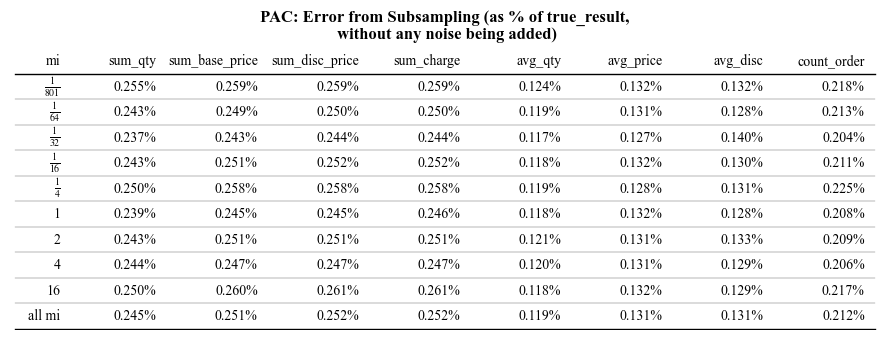

In [46]:
d=sample_errors_df.groupby('mi').mean()
d.loc['all mi'] = sample_errors_df[OUTPUT_COLS].mean()

fig, ax = plt.subplots(figsize=(5+(0.5*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: Error from Subsampling (as % of true_result,\n without any noise being added)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_sample_error.jpg", bbox_inches='tight')
plt.show()

In [47]:
print("PAC: How much noise are we adding? (actual noise amounts sampled from the normal distribution, absolute value)")
# abs before mean
saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})

PAC: How much noise are we adding? (actual noise amounts sampled from the normal distribution, absolute value)


/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_75159/2429859456.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})


step      abs(chosen_noise)                                              \
query               sum_qty sum_base_price sum_disc_price    sum_charge   
mi                                                                        
0.001248       1.186251e+07   4.410503e+08   4.397739e+08  4.622369e+08   
0.015625       3.518635e+06   1.263838e+08   1.240949e+08  1.254993e+08   
0.031250       2.279314e+06   9.310200e+07   9.068803e+07  9.035351e+07   
0.062500       1.626843e+06   6.396105e+07   6.218953e+07  6.544504e+07   
0.250000       8.532990e+05   3.345083e+07   3.227754e+07  3.168461e+07   
1.000000       4.092880e+05   1.574367e+07   1.579893e+07  1.628017e+07   
2.000000       3.043874e+05   1.152651e+07   1.096676e+07  1.111922e+07   
4.000000       2.179674e+05   8.446838e+06   7.611986e+06  7.957854e+06   
16.000000      1.037209e+05   4.103790e+06   3.853718e+06  3.904112e+06   

step                                                               
query           avg_qty      avg_price     avg_disc   count_order  
mi                                                                 
0.001248   21983.786036  880273.659358  1043.616143  2.183599e+06  
0.015625    6318.912900  238364.651994   293.635523  6.339349e+05  
0.031250    4440.534892  172801.379259   204.582704  4.521200e+05  
0.062500    3214.521978  117903.427626   141.448412  3.203382e+05  
0.250000    1593.272950   59194.860248    72.350678  1.507145e+05  
1.000000     769.800923   29603.390326    34.378980  7.989207e+04  
2.000000     548.187015   21228.887864    25.387248  5.666462e+04  
4.000000     378.349975   15338.715505    18.114367  3.867417e+04  
16.000000    192.734248    7412.641599     8.862730  1.974108e+04

/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_75159/211596906.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  d = saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})


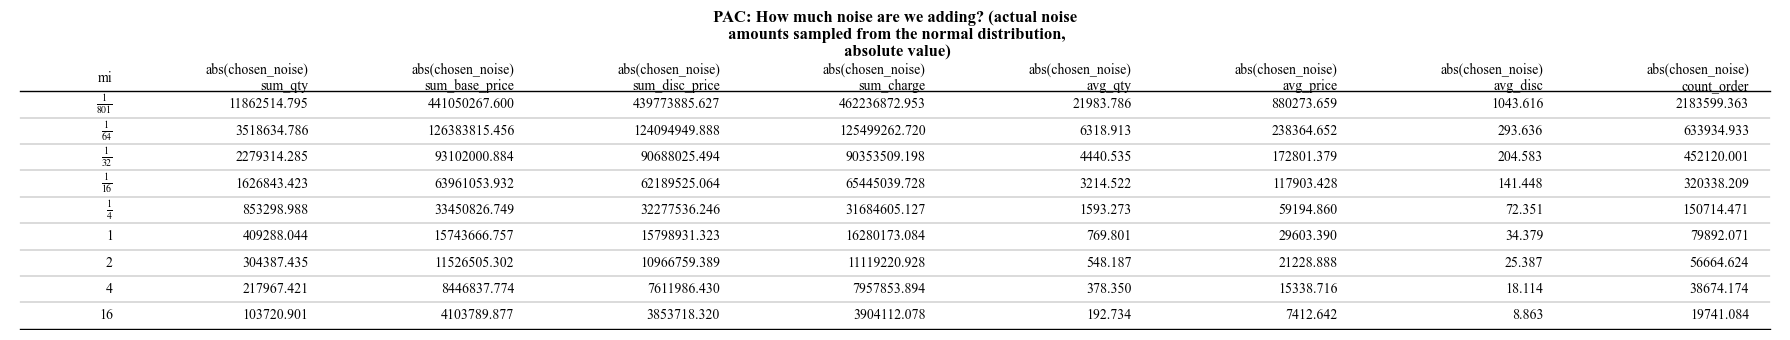

In [48]:
d = saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        title='\n'.join(c),
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: How much noise are we adding? (actual noise\n amounts sampled from the normal distribution,\n absolute value)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_chosen_noise.jpg", bbox_inches='tight')
plt.show()

In [49]:
print("Avg. value of unnoised sample used by PAC")
display(saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean())  # average per MI, shouldn't be different
display(saved_steps_df[['chosen_sample']].mean().to_frame(name='all mi').T)  # sample shouldn't change with MI, so we can find the overall average

Avg. value of unnoised sample used by PAC


/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_75159/883409176.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  display(saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean())  # average per MI, shouldn't be different


step      chosen_sample                                              \
query           sum_qty sum_base_price sum_disc_price    sum_charge   
mi                                                                    
0.001248    3773991.716   5.320358e+09   5.053732e+09  5.256354e+09   
0.015625    3773950.112   5.320303e+09   5.053669e+09  5.256299e+09   
0.031250    3774197.670   5.320858e+09   5.054215e+09  5.256868e+09   
0.062500    3774228.142   5.320790e+09   5.054119e+09  5.256787e+09   
0.250000    3774882.636   5.321698e+09   5.054984e+09  5.257663e+09   
1.000000    3773398.448   5.319489e+09   5.052925e+09  5.255532e+09   
2.000000    3774066.810   5.320867e+09   5.054208e+09  5.256839e+09   
4.000000    3773946.172   5.320305e+09   5.053659e+09  5.256275e+09   
16.000000   3774109.228   5.320542e+09   5.053886e+09  5.256531e+09   

step                                                      
query        avg_qty     avg_price  avg_disc count_order  
mi                                                        
0.001248   25.536498  35999.895448  0.050142  147788.140  
0.015625   25.535719  35998.819067  0.050144  147791.026  
0.031250   25.537919  36003.317367  0.050141  147787.970  
0.062500   25.536568  36000.657735  0.050147  147796.998  
0.250000   25.539515  36004.712748  0.050148  147805.610  
1.000000   25.537610  36001.242231  0.050141  147758.476  
2.000000   25.535852  36001.709424  0.050144  147794.810  
4.000000   25.536877  36000.504713  0.050146  147784.154  
16.000000  25.538174  36002.380207  0.050148  147783.036

step   chosen_sample                                                         \
query        sum_qty sum_base_price sum_disc_price    sum_charge    avg_qty   
all mi  3.774086e+06   5.320579e+09   5.053933e+09  5.256572e+09  25.537192   

step                                           
query      avg_price  avg_disc    count_order  
all mi  36001.470993  0.050144  147787.802222

/var/folders/g4/jxkqkb_d5170qh291jwd0t_h0000gn/T/ipykernel_75159/3303776140.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  d = saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean()


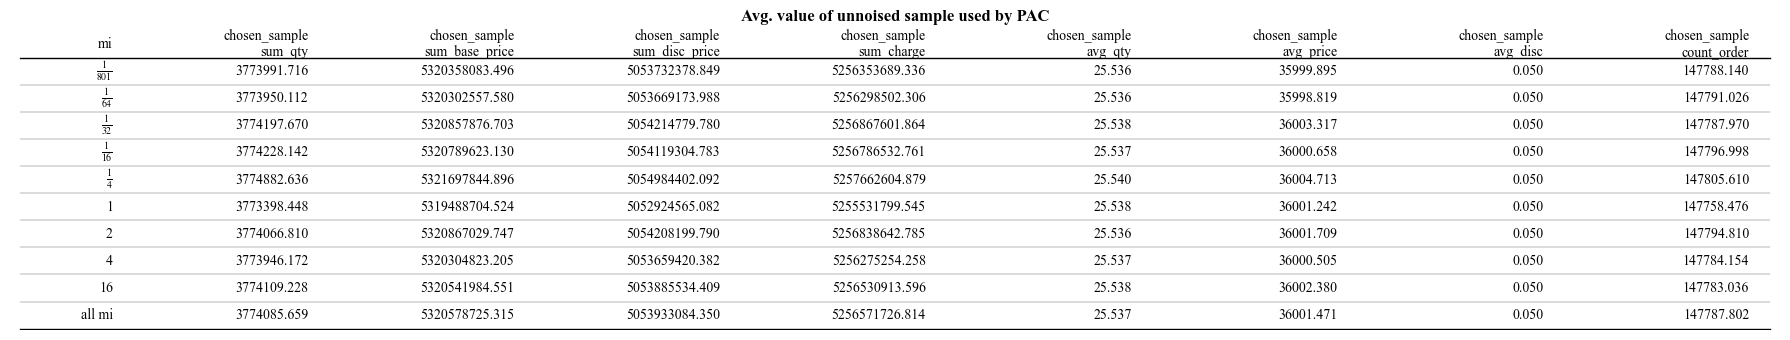

In [50]:
d = saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean()
d.loc['all mi'] = saved_steps_df[['chosen_sample']].mean()

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        title='\n'.join(c),
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("Avg. value of unnoised sample used by PAC")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_unnoised_samples.jpg", bbox_inches='tight')
plt.show()

In [51]:
# How much total error is there in PAC? Compute % error on our samples after noise was added
total_errors = [relative_error_percent(s, true_result) for s in saved_steps_df['release'].to_numpy()]
total_errors_df = pd.DataFrame(total_errors, columns=OUTPUT_COLS)
total_errors_df.insert(0, 'mi', saved_steps_df['mi'].values)  # Insert 'mi' at the beginning
print("PAC: Total Error (as % of true_result)")
total_errors_df.groupby('mi').mean()

PAC: Total Error (as % of true_result)


sum_qty  sum_base_price  sum_disc_price  sum_charge  \
mi                                                                  
0.001248   314.296271        8.296379        8.704968    8.804457   
0.015625    93.225848        2.391556        2.469943    2.395386   
0.031250    60.389206        1.786233        1.825233    1.740512   
0.062500    43.097830        1.232851        1.260846    1.266859   
0.250000    22.615730        0.674887        0.678330    0.658181   
1.000000    10.848043        0.392232        0.395948    0.402883   
2.000000     8.062290        0.331053        0.323635    0.340491   
4.000000     5.768842        0.291093        0.288422    0.295619   
16.000000    2.753929        0.272528        0.269175    0.271158   

                avg_qty    avg_price      avg_disc  count_order  
mi                                                               
0.001248   86084.030933  2445.066973  2.081214e+06  1477.506058  
0.015625   24743.567413   662.086132  5.855776e+05   428.942480  
0.031250   17388.227142   479.976903  4.079855e+05   305.921049  
0.062500   12587.409866   327.486628  2.820811e+05   216.754297  
0.250000    6238.939423   164.411050  1.442841e+05   101.984181  
1.000000    3014.386365    82.231561  6.855969e+04    54.061126  
2.000000    2146.590746    58.961665  5.062807e+04    38.321926  
4.000000    1481.539161    42.609687  3.612427e+04    26.171267  
16.000000    754.705378    20.590759  1.767435e+04    13.365233

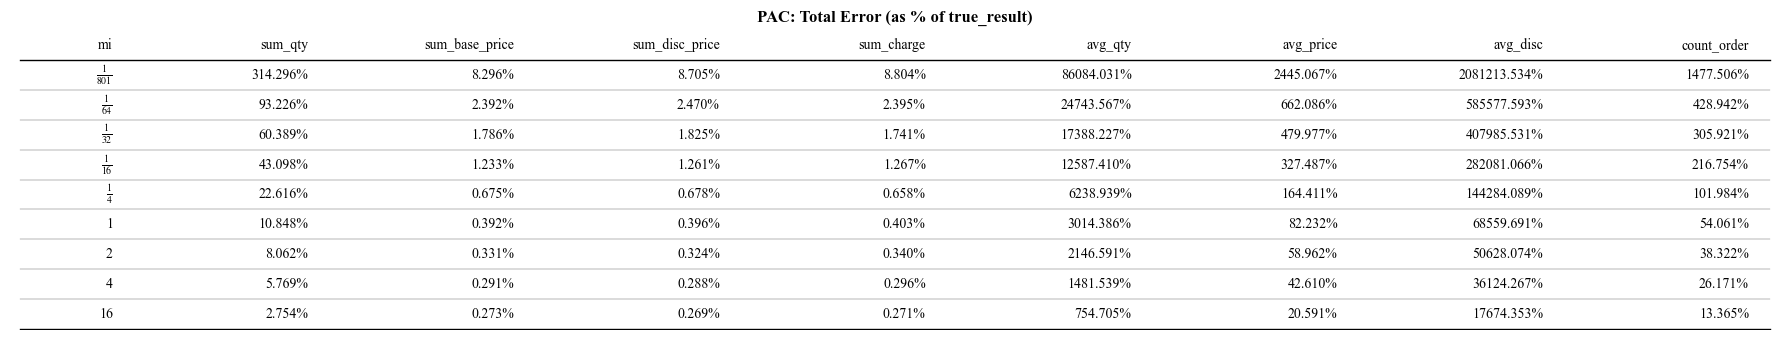

In [52]:
d=total_errors_df.groupby('mi').mean()

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: Total Error (as % of true_result)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_error_total.jpg", bbox_inches='tight')
plt.show()

In [53]:
print("PAC: Increase in Avg. % error due to noise being added (as % of true_result)")
delta_error_from_noise = pd.concat(
    [
        saved_steps_df['mi'].reset_index(drop=True),
        pd.DataFrame(
            (np.array([relative_error_percent(s, true_result) for s in saved_steps_df['release'].to_numpy()]) -
             np.array([relative_error_percent(s, true_result) for s in saved_steps_df['chosen_sample'].to_numpy()])),
            columns=OUTPUT_COLS
        )
    ],
    axis=1
)
delta_error_from_noise.groupby('mi').mean()

PAC: Increase in Avg. % error due to noise being added (as % of true_result)


sum_qty  sum_base_price  sum_disc_price  sum_charge  \
mi                                                                  
0.001248   314.041350        8.037732        8.445723    8.545220   
0.015625    92.983313        2.142235        2.220195    2.145773   
0.031250    60.151831        1.542873        1.581694    1.496378   
0.062500    42.854718        0.981717        1.009103    1.015192   
0.250000    22.365282        0.416994        0.420447    0.400031   
1.000000    10.609150        0.146839        0.150546    0.156953   
2.000000     7.819703        0.080378        0.072625    0.089217   
4.000000     5.525306        0.044407        0.041721    0.048848   
16.000000    2.503655        0.012624        0.008461    0.010633   

                avg_qty    avg_price      avg_disc  count_order  
mi                                                               
0.001248   86083.907136  2444.935366  2.081213e+06  1477.287943  
0.015625   24743.448871   661.954953  5.855775e+05   428.729000  
0.031250   17388.110456   479.849758  4.079854e+05   305.716704  
0.062500   12587.291555   327.354979  2.820809e+05   216.543770  
0.250000    6238.819937   164.283236  1.442840e+05   101.759428  
1.000000    3014.268310    82.099141  6.855956e+04    53.852968  
2.000000    2146.470085    58.830563  5.062794e+04    38.113239  
4.000000    1481.418900    42.478352  3.612414e+04    25.965734  
16.000000    754.587259    20.458353  1.767422e+04    13.148615

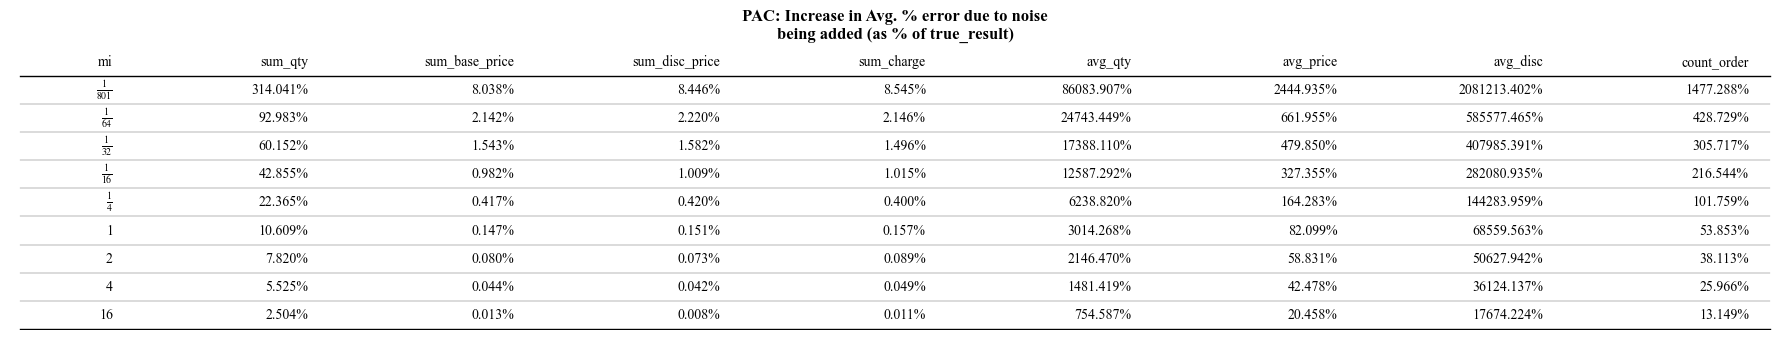

In [54]:
d=delta_error_from_noise.groupby('mi').mean()

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        )
plt.title("PAC: Increase in Avg. % error due to noise\nbeing added (as % of true_result)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_error_noise.jpg", bbox_inches='tight')
plt.show()

In [55]:
### Combined % Error Table
d = pd.concat([
    sample_errors_df.groupby('mi').mean(),  # % error from subsampling
    delta_error_from_noise.groupby('mi').mean(),  # % error from noise
    total_errors_df.groupby('mi').mean(),  # % total error
], axis=1)
d.columns = ['Subsampling', 'Added Noise', 'Total Error']

fig, ax = plt.subplots(figsize=(2+(2*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        group="Error Sources",
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns[:-1]],
    ColumnDefinition(
        name=d.columns[-1],
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    )]
tbl = Table(d,
            column_definitions=col_defs,
            row_dividers=True,
            footer_divider=True,
            ax=ax,
        )
#plt.title("PAC: Error Breakdown")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_error_breakdown.jpg", bbox_inches='tight')
plt.show()

ValueError: Length mismatch: Expected axis has 24 elements, new values have 3 elements

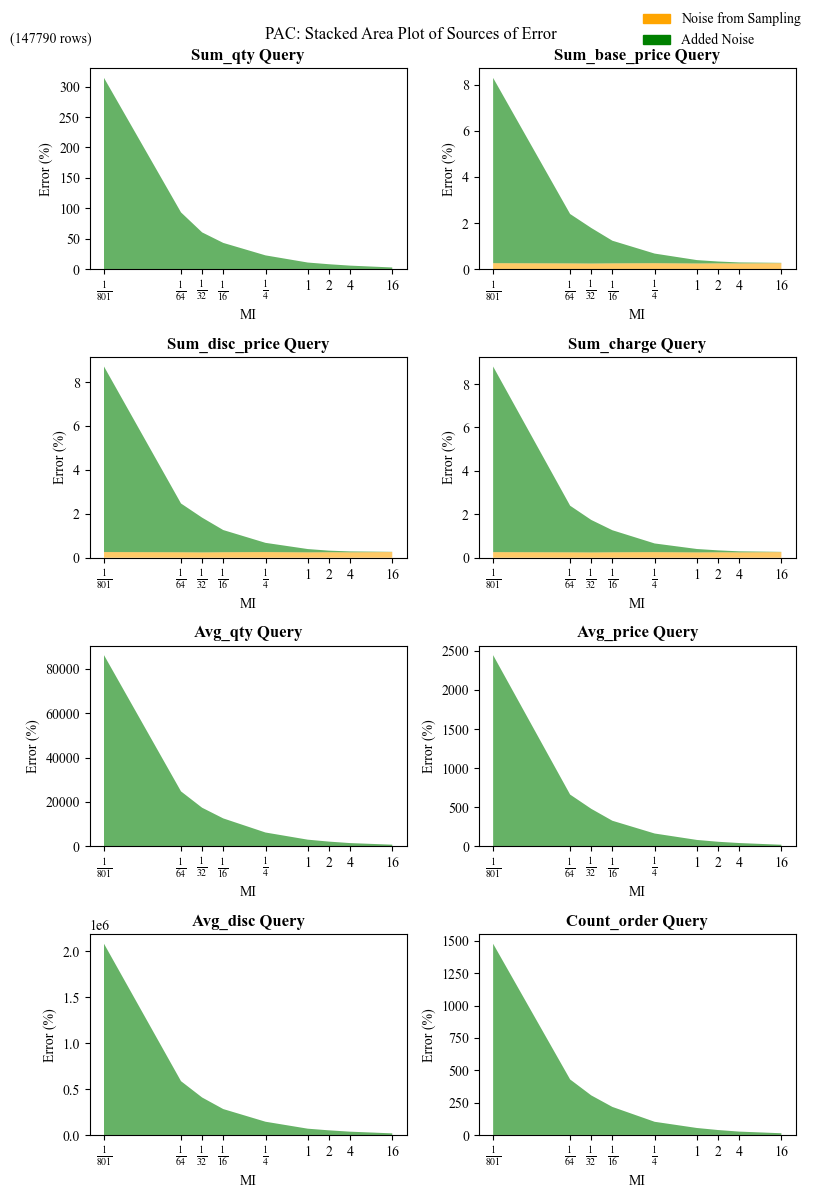

In [56]:
fig, axs = plt.subplots(4, 2, figsize=(8, 12))

psample_errors = sample_errors_df.groupby('mi').mean()
pnoise_errors = delta_error_from_noise.groupby('mi').mean()

for i, query in enumerate(OUTPUT_COLS):
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.stackplot(psample_errors.index, psample_errors[query], pnoise_errors[query], 
        labels=['Sample Error', 'Noise Error'], colors=['orange', 'green'], alpha=0.6)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)


    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Error (%)')

fig.legend(handles=[
    Patch(facecolor='orange', edgecolor='orange', label='Noise from Sampling'),
    Patch(facecolor='green', edgecolor='green', label='Added Noise'),
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("PAC: Stacked Area Plot of Sources of Error")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/pac_error_breakdown.jpg", bbox_inches='tight')
plt.show()